# Nonlinear Elasticity in a multipatch domain


In [20]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['bmat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [21]:
p = 3   # spline degree 
n_el = (50, 10)   # number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [22]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

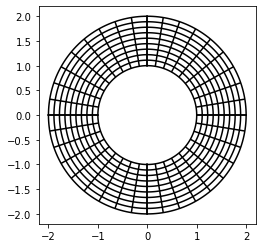

In [23]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [24]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [25]:
# source term f 
def f(x, y): return (0.0, 0.0)

# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

# Bilinear form for linear elasticity problem
def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u, e_v) * dx + Lam * div(u) * div(v) * dx) 
    return vf

#Neumann BC
def gN(x, y): return (1.5e-4, -1.5e-4) 

neu_data = [
    (3,'right',gN) 
]

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [26]:
first = True
for p in range(MP_block.numpatches):
    X = MP_block.patch_to_global(p)
    
    # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
    #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
    
    # The whole patch-local stiffness matrix
    A_p = assemble.assemble_vf(linelast_vf(2), kvs_ux, geo=geo_ux, symmetric=True)
    
    # The patch-local right-hand side
    b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel()
      
    # The patch-local Neumann boundary data
    for item in neu_data:
        if item[0]==p:
            N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
            bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
            for c in range(2):
                offset = MP_block.compute_local_offset_for_component(p,c)
                for i in range(len(bdofs)):
                    b_p[bdofs[i]+offset] += N_e[c,i,0]
    
    if first:
        A = X @ A_p @ X.T
        b = X @ b_p
        first = False
    else:
        A += X @ A_p @ X.T
        b += X @ b_p

#print(shape(A))
#print(shape(b))

In [27]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)
# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero )
])

In [28]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, b, bc)
u_sol = solvers.make_solver(LS.A, spd=True).dot(LS.b)
u = LS.complete(u_sol)

print(u)

[ 0.0445965   0.0445858   0.04470223 ... -0.15159252 -0.14101295
 -0.13443154]


In [29]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, p, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    
    # restrict solution to each individual patch
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    
    # grid variables
    ref = 10
    # evaluate displacement and "pressure" over a grid in the parameter domain
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    
    figsize(10,10)
    fig, ax = plt.subplots()
    
     # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)
        
    colorbar();
    axis('equal')


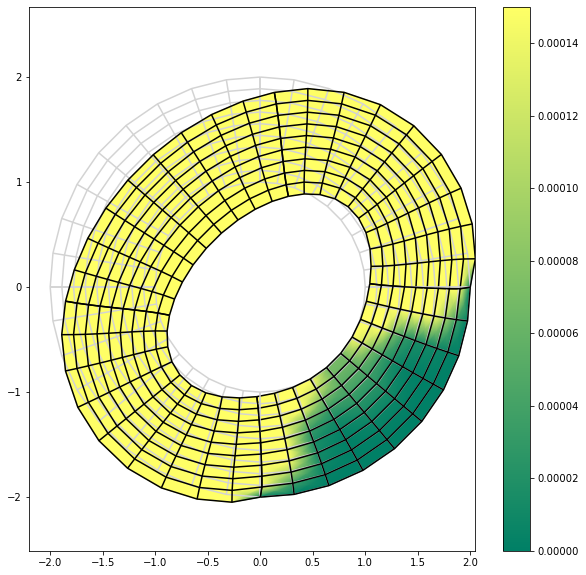

In [30]:
# print deformation plot (linear elasticity)
get_defplot(u, p, patches_u, kvs_u)


In [31]:
# Compute solution of nonlinear elasticity problem

In [32]:
#split the solution into its components (displacement in x- and y- direction)
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
def get_components(u):
    """Split solution vector into displacement components."""
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2*N].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [33]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

# nonlinear variational form
def apply_nl(u):
    dis = get_components(u)
    z_lam = Lam* assemble.assemble('(div(dis)*tr(grad(v))+ 1/2 *tr( grad(dis).T *grad(dis)) *tr(grad(v)) + inner(div(dis)*grad(dis), grad(v)) + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v))) *dx'
                             , kvs_u, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('(inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v)) + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v))) *dx'
                                    , kvs_u, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u):
    dis = get_components(u)
    A_lin_lam = Lam* assemble.assemble('inner((div(dis)*grad(u)+ 1/2 *tr( grad(dis).T *grad(dis)) * grad(u) + div(u)*grad(dis) + tr(grad(dis).T*grad(u)) * grad(dis)), grad(v)) + div(u)*tr(grad(v)) + tr(grad(dis).T*grad(u)) * tr(grad(v)) * dx'
                              , kvs_u, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    
    A_lin_mu = Mu * assemble.assemble('inner((grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis))+ ( grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)) + ( grad(dis)*grad(u)+ grad(dis)*grad(u).T + grad(dis)*grad(dis).T * grad(u) + grad(dis)*grad(u).T*grad(dis)) ),grad(v)) * dx'
                              , kvs_u, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    return A_lin_lam +A_lin_mu

In [34]:
# solve linearized system 
### first iteration ###
print(shape(b)[0])
dd = shape(b)[0]
#initial value
u= np.zeros(dd)

5408


In [35]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem (p, u, neu_data):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]

        # The whole patch-local stiffness matrix
        A_p = linearized(u) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = -apply_nl(u) # rhs - apply_nl(u), for rhs= (0,...,0) # Newton-Raphson iteration
        #b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() -apply_nl(u) # for arbitrary rhs

        # The patch-local Neumann boundary data
        for item in neu_data:
            if item[0]==p:
                N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i,0]

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p
    
    return A, b


In [36]:
# solve linearized system 
#initial value
#u= np.zeros(dd)
print(u)

### first iteration ###
A, b= ass_nonlinsystem (p, u, neu_data)

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
u_d= solvers.make_solver(LS.A).dot(LS.b)
u_d = LS.complete(u_d)
u += u_d

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)
print(normed_du0)
print(u)

[0. 0. 0. ... 0. 0. 0.]
33.73458295198589
[ 0.17022287  0.15973261  0.14297675 ... -0.71317046 -0.71970216
 -0.7246897 ]


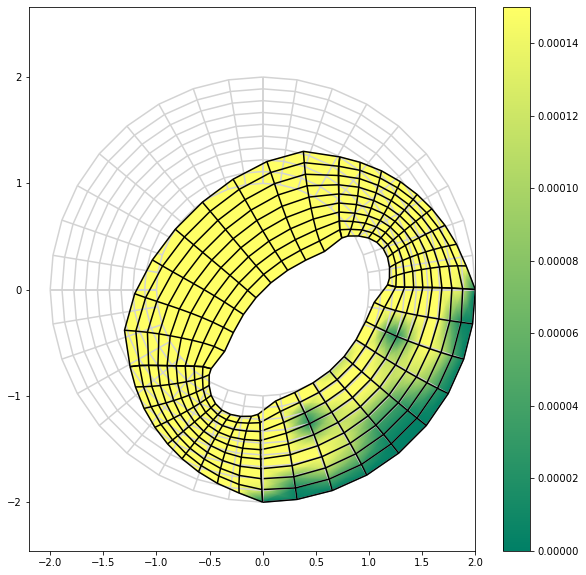

In [37]:
# print deformation plot (after first iteration)
get_defplot(u, p, patches_u, kvs_u)


2
norm(delta_u) =  10.807978786908643
step size u_d =  22.92660416507725
3
norm(delta_u) =  25.46790763067058
step size u_d =  14.659928843761938
4
norm(delta_u) =  0.7571548419404812
step size u_d =  24.7107527887301
5
norm(delta_u) =  0.7912827267559541
step size u_d =  0.03412788481547291
6
norm(delta_u) =  6.316114492891731
step size u_d =  5.524831766135777
7
norm(delta_u) =  0.48322837558374626
step size u_d =  5.832886117307985
8
norm(delta_u) =  0.44876209297021646
step size u_d =  0.0344662826135298
9
norm(delta_u) =  0.43250291738986796
step size u_d =  0.016259175580348506
10
norm(delta_u) =  0.445498292091408
step size u_d =  0.012995374701540052


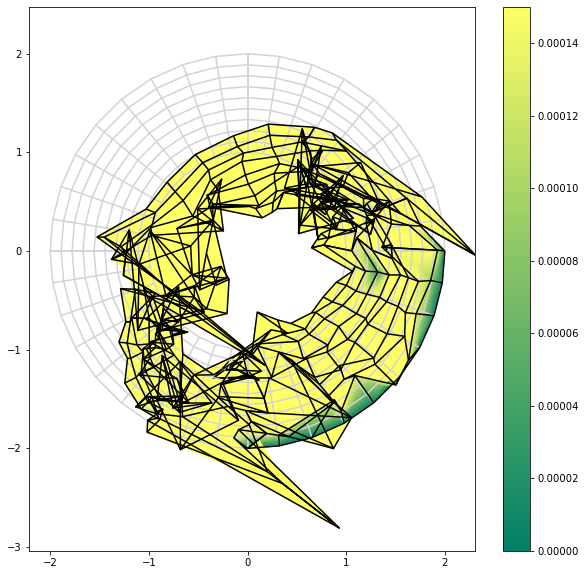

In [38]:
# solve linearized variational problem
epsilon= 1e-3
count= 1

stepsizes =[]

while True:
    count+=1
    print(count)
    
    # Assemble matrices and rhs!
    A, b= ass_nonlinsystem (p, u, neu_data)
    
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    u_d = solvers.make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d)
    #update
    u += u_d
    
    normed_du = np.linalg.norm(u_d)
    stepsize_du = abs(normed_du0-normed_du)
    print('norm(delta_u) = ', normed_du)
    print ('step size u_d = ', stepsize_du)
    
    stepsizes.append(stepsize_du)
    
    if abs(normed_du0-normed_du) < epsilon:
        break
    elif count == 10:
        break
        
    normed_du0 = normed_du
    
# print deformation plot
get_defplot(u, p, patches_u, kvs_u)
#print(u)